# Traffic Sign Recognition

On the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**imports**

In [2]:
import re

In [3]:
from fastai import *
from fastai.vision import *

## Get the data

In [4]:
path = Path('data/gtsrb/')
path.ls()

[PosixPath('data/gtsrb/FullIJCNN2013.zip'),
 PosixPath('data/gtsrb/test'),
 PosixPath('data/gtsrb/train'),
 PosixPath('data/gtsrb/new'),
 PosixPath('data/gtsrb/sign_names.csv'),
 PosixPath('data/gtsrb/.ipynb_checkpoints'),
 PosixPath('data/gtsrb/GT-final_test.csv')]

In [5]:
np.random.seed(2)  # seed ensures that the same validation set is used all the time

**get the original class names**

In [6]:
sign_names = pd.read_csv(path/'sign_names.csv')
sign_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


**change the id's to map to the folder names**

In [7]:
sign_names['ClassId'] = sign_names['ClassId'].apply(
    lambda x: '0000' + str(x) if x < 10 else '000' + str(x))
sign_names.head()

,ClassId,SignName
0,00000,Speed limit (20km/h)
1,00001,Speed limit (30km/h)
2,00002,Speed limit (50km/h)
3,00003,Speed limit (60km/h)
4,00004,Speed limit (70km/h)


In [8]:
sign_names.loc[sign_names['ClassId'] == '00000', 'SignName'].iloc[0]

'Speed limit (20km/h)'

In [9]:
def get_label(x):
    '''
        function maps numerical id to traffic sign name
    '''
    x = str(x)
    match = re.search(r'\d{5}', x).group(0)
    return sign_names.loc[sign_names['ClassId'] == match, 'SignName'].iloc[0]

**create databunch**

In [10]:
src = (ImageItemList.from_folder(path/'train')
        .random_split_by_pct()
        .label_from_func(get_label)
        .add_test(ItemList.from_folder(path/'test')))

In [11]:
tfms = get_transforms(do_flip=False, max_rotate=0)

In [12]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [13]:
len(data.train_ds), len(data.test_ds)

(31368, 12630)

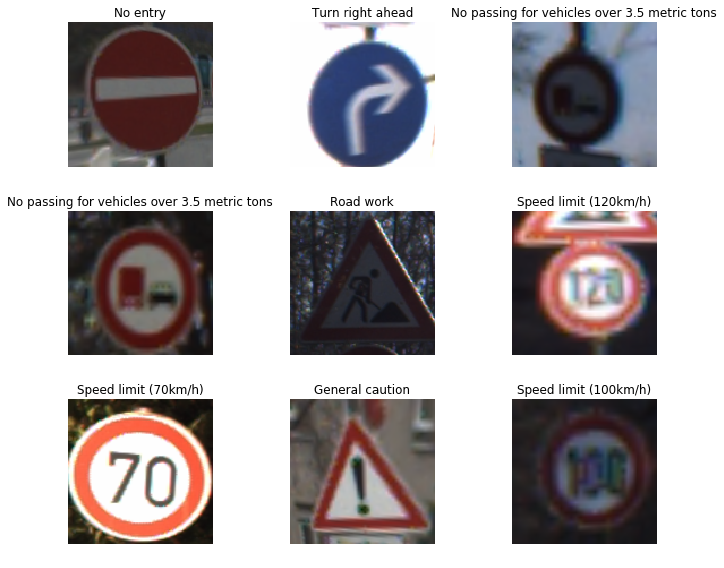

In [14]:
data.show_batch(rows=3, figsize=(10, 8))

In [15]:
data.c  # number of classes

43

## Create the model

In [16]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


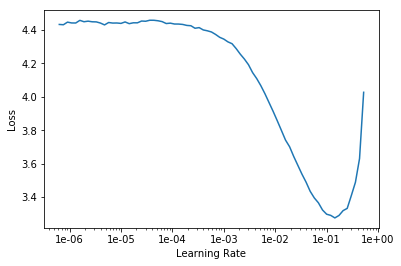

In [18]:
learn.recorder.plot()

In [19]:
lr = 1e-2

In [20]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.860161,0.513405,0.162862
2,0.350741,0.171122,0.057391
3,0.207532,0.099380,0.030098
4,0.148592,0.075611,0.022956
5,0.099999,0.041080,0.013391
6,0.091798,0.037506,0.010203
7,0.055646,0.023692,0.007142
8,0.039197,0.024208,0.005994
9,0.038747,0.016719,0.004591
10,0.029121,0.011144,0.002806


In [21]:
learn.save('stage-128-1')

### Unfreeze

In [27]:
learn.load('stage-128-1');

In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


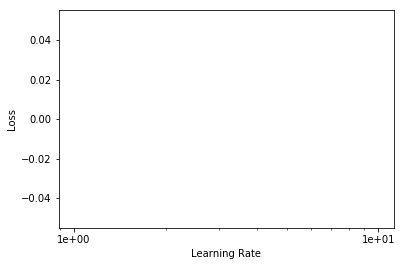

In [30]:
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(10, slice(1e-8, lr/10))

epoch,train_loss,valid_loss,error_rate
1,0.005449,0.007388,0.001913
2,0.005641,0.007861,0.001913
3,0.006691,0.007107,0.001658
4,0.005635,0.008307,0.002296
5,0.004036,0.007275,0.002041
6,0.006820,0.006255,0.001403
7,0.004001,0.005787,0.001275
8,0.004291,0.006003,0.001020
9,0.005549,0.005977,0.001148
10,0.003322,0.006147,0.001275


In [32]:
learn.save('stage-128-2')

### Progressive resizing: increase the size of images

In [33]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

In [34]:
learn.data = data

In [35]:
learn.freeze()

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


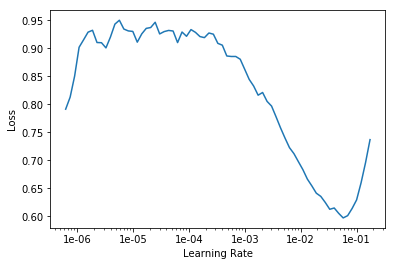

In [37]:
learn.recorder.plot()

In [38]:
lr = 1e-2

In [39]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.153075,0.044236,0.012626
2,0.063600,0.028252,0.009310
3,0.041332,0.024180,0.006887
4,0.034615,0.017000,0.003954
5,0.026917,0.012832,0.003061
6,0.020506,0.011739,0.002933
7,0.015872,0.009550,0.002168
8,0.007441,0.005993,0.000893
9,0.008676,0.005988,0.000893
10,0.003385,0.006232,0.001148


In [40]:
learn.save('stage-224-1')

In [41]:
learn.unfreeze()

In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


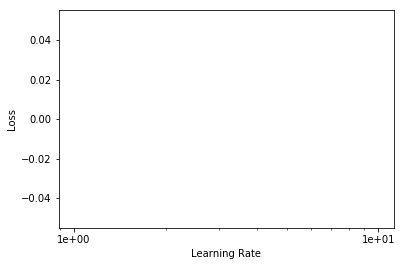

In [43]:
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(10, slice(1e-9, 1e-5))

epoch,train_loss,valid_loss,error_rate
1,0.001950,0.005943,0.000893
2,0.002574,0.006093,0.000893
3,0.002705,0.005768,0.001020
4,0.002659,0.006021,0.000893
5,0.005010,0.006064,0.001020
6,0.003003,0.006038,0.000893
7,0.003951,0.005905,0.000893
8,0.004235,0.006040,0.000893
9,0.002241,0.005974,0.001020
10,0.002952,0.005807,0.000893


In [45]:
learn.save('stage-2-224')

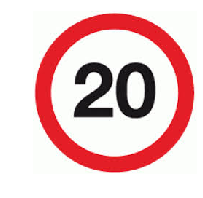

In [53]:
test_image = open_image('20.jpeg')
test_image.show()

In [54]:
learn.predict(test_image)

(Category Vehicles over 3.5 metric tons prohibited,
 tensor(40),
 tensor([1.3560e-09, 4.2293e-08, 6.2917e-08, 1.7928e-08, 1.2323e-09, 7.9914e-05,
         1.4340e-08, 4.0033e-06, 2.4502e-08, 2.5072e-04, 1.4494e-05, 3.5375e-07,
         5.7047e-04, 1.1572e-08, 1.4294e-09, 1.0146e-06, 2.1641e-06, 2.3650e-07,
         1.2309e-06, 1.4727e-07, 5.6044e-03, 6.4833e-05, 5.6022e-08, 4.3761e-05,
         7.4324e-10, 6.6238e-07, 9.0975e-07, 2.6484e-07, 3.3156e-10, 1.1190e-08,
         1.1218e-01, 4.4638e-07, 1.5105e-03, 3.3896e-02, 8.5293e-07, 3.2675e-05,
         3.9558e-10, 1.5183e-09, 6.4473e-05, 9.4021e-08, 8.4565e-01, 2.1336e-05,
         4.5971e-09]))

**wrong prediction was made**

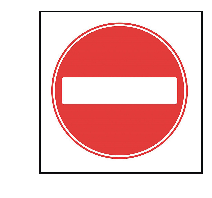

In [57]:
test_image = open_image('test.jpg')
test_image.show()

In [58]:
learn.predict(test_image)

(Category No vehicles,
 tensor(20),
 tensor([5.0064e-08, 8.4166e-04, 1.6001e-04, 2.4934e-08, 3.4145e-09, 1.7770e-07,
         1.0853e-05, 5.5319e-09, 5.2235e-04, 7.2283e-07, 3.6474e-06, 1.3331e-05,
         5.7500e-03, 2.7908e-09, 1.2401e-07, 4.7776e-03, 7.9458e-02, 1.6101e-01,
         1.5138e-07, 2.7411e-04, 7.3686e-01, 2.1258e-04, 1.2178e-04, 2.1592e-04,
         6.1908e-08, 1.0055e-06, 4.0748e-05, 4.5964e-06, 1.6672e-06, 8.3471e-05,
         4.7206e-06, 1.4842e-06, 1.3178e-06, 8.6304e-09, 2.9599e-05, 1.8493e-03,
         1.0354e-09, 8.2918e-06, 8.7966e-06, 5.6491e-08, 7.7289e-03, 2.5179e-06,
         3.9544e-07]))

**another wrong prediction**

# Fine tune on new data

In [92]:
learn.load('stage-2-224');

In [93]:
src = (ImageItemList.from_folder(path/'new')
        .random_split_by_pct()
        .label_from_func(get_label)
        .add_test(ItemList.from_folder(path/'test')))

In [94]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

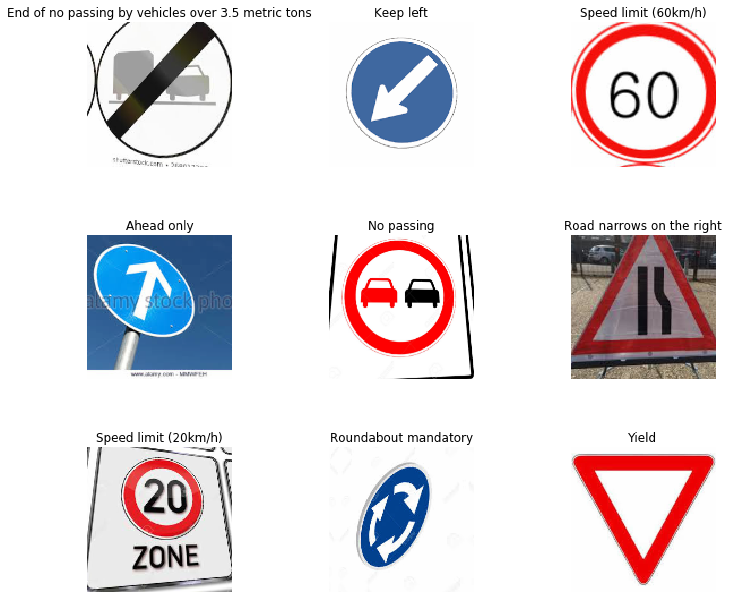

In [95]:
data.show_batch(rows=3, figsize=(10, 9))

In [96]:
learn.data = data

In [97]:
learn.freeze()

In [98]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


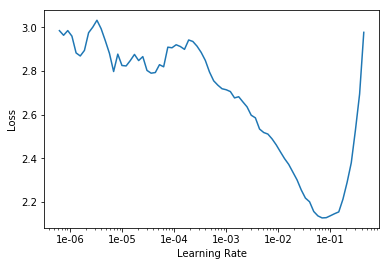

In [99]:
learn.recorder.plot()

In [100]:
lr = 1e-2

In [101]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,2.627505,1.932306,0.240741
2,2.131097,1.098100,0.159259
3,1.658427,0.802649,0.140741
4,1.284280,0.685823,0.129630
5,1.026151,0.599107,0.114815
6,0.849037,0.527093,0.103704
7,0.699221,0.487519,0.103704
8,0.606894,0.503567,0.103704
9,0.530043,0.495292,0.100000
10,0.470713,0.496548,0.100000


In [102]:
learn.save('finetune-128-1')

In [103]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


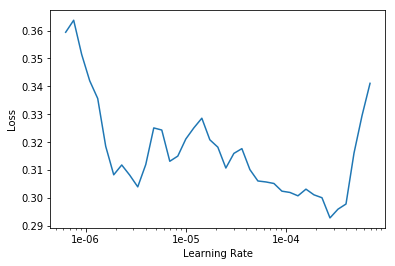

In [104]:
learn.recorder.plot()

In [105]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate
1,0.314045,0.517620,0.103704
2,0.296540,0.466707,0.100000
3,0.322179,0.527924,0.103704
4,0.306394,0.686438,0.114815
5,0.274650,0.345573,0.081481
6,0.237589,0.327933,0.077778
7,0.194093,0.295827,0.059259
8,0.169484,0.322451,0.059259
9,0.141968,0.322507,0.055556
10,0.116762,0.329338,0.059259


In [106]:
learn.save('finetune-128-2')

## Progressive resizing

In [107]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

In [108]:
learn.data = data

In [109]:
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


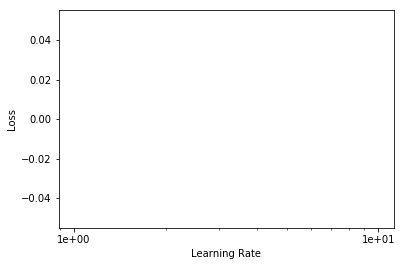

In [110]:
learn.recorder.plot()

In [111]:
lr = 1e-2
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.355769,0.218675,0.037037
2,0.303355,0.175840,0.037037
3,0.237266,0.154988,0.022222
4,0.196649,0.128481,0.022222
5,0.170178,0.146355,0.037037
6,0.145950,0.129748,0.029630
7,0.127604,0.119292,0.022222
8,0.108113,0.115105,0.018519
9,0.105350,0.110294,0.014815
10,0.093977,0.113518,0.014815


In [112]:
learn.save('finetune-224-1')

In [113]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


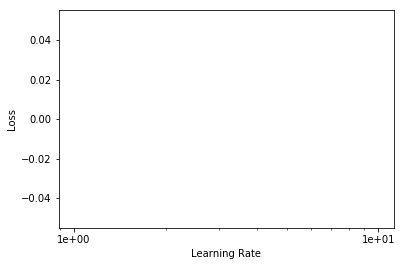

In [114]:
learn.recorder.plot()

In [115]:
learn.fit_one_cycle(10, slice(1e-9, 1e-7))

epoch,train_loss,valid_loss,error_rate
1,0.054672,0.114022,0.014815
2,0.054788,0.109399,0.014815
3,0.065424,0.111309,0.014815
4,0.062330,0.112047,0.014815
5,0.070953,0.110951,0.014815
6,0.071630,0.113610,0.014815
7,0.070335,0.112822,0.014815
8,0.071304,0.114566,0.014815
9,0.070047,0.113760,0.014815
10,0.065123,0.114658,0.018519


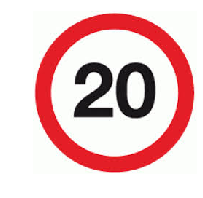

In [116]:
test_image = open_image('20.jpeg')
test_image.show()

In [117]:
learn.predict(test_image)

(Category Speed limit (20km/h),
 tensor(30),
 tensor([3.6535e-12, 2.8858e-11, 5.8589e-09, 2.1522e-10, 1.0428e-10, 1.1474e-10,
         1.1394e-10, 4.9479e-10, 1.3124e-09, 3.8715e-11, 4.5348e-10, 3.5301e-11,
         1.1821e-09, 5.2497e-10, 1.0637e-09, 4.7860e-09, 1.3287e-09, 6.8525e-09,
         2.5604e-09, 4.2102e-09, 8.0699e-10, 2.8309e-08, 1.7695e-10, 7.9518e-12,
         1.2649e-09, 1.3090e-10, 3.1525e-10, 3.6622e-08, 4.6289e-10, 1.6119e-05,
         9.9998e-01, 8.1787e-08, 2.7552e-07, 4.8824e-08, 1.3482e-08, 6.7658e-10,
         2.5173e-09, 5.5611e-12, 4.4525e-12, 2.1026e-12, 9.4570e-09, 2.7238e-08,
         2.2434e-11]))

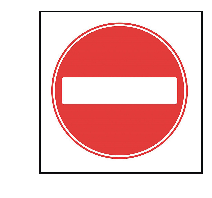

In [118]:
test_image = open_image('test.jpg')
test_image.show()

In [119]:
learn.predict(test_image)

(Category No entry,
 tensor(17),
 tensor([1.7671e-18, 2.8339e-19, 3.3457e-20, 1.4866e-18, 3.7514e-18, 1.8309e-16,
         5.3672e-18, 3.0854e-18, 9.7163e-15, 2.1456e-16, 1.0876e-15, 9.2533e-21,
         3.0333e-17, 1.7467e-20, 1.7622e-19, 3.1265e-17, 1.3215e-14, 1.0000e+00,
         6.5064e-14, 9.3972e-12, 3.2505e-13, 8.2484e-18, 5.7429e-17, 6.8417e-17,
         7.1219e-17, 2.3048e-21, 1.2026e-18, 5.3929e-17, 4.2794e-17, 1.4172e-17,
         3.4170e-18, 1.1906e-20, 3.2082e-19, 4.2396e-20, 2.2448e-17, 4.0189e-18,
         3.0593e-15, 1.9536e-14, 1.8556e-17, 1.8538e-16, 9.2581e-15, 1.8535e-18,
         7.7011e-17]))

## Model interpretation

In [120]:
interp = ClassificationInterpretation.from_learner(learn)

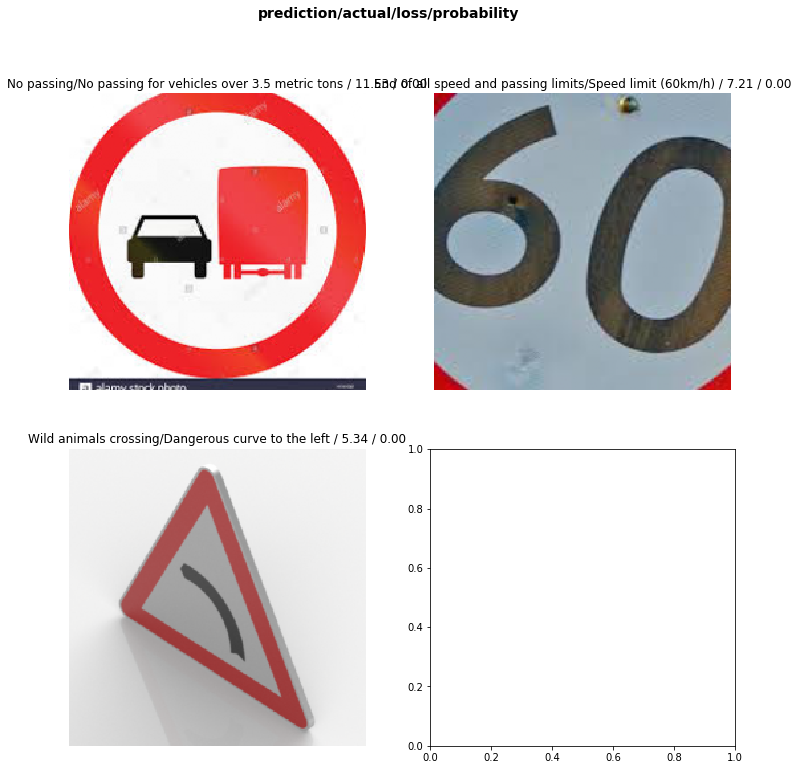

In [121]:
interp.plot_top_losses(3)

In [33]:
data.classes

['Ahead only',
 'Beware of ice/snow',
 'Bicycles crossing',
 'Bumpy road',
 'Children crossing',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'End of all speed and passing limits',
 'End of no passing',
 'End of no passing by vehicles over 3.5 metric tons',
 'End of speed limit (80km/h)',
 'General caution',
 'Go straight or left',
 'Go straight or right',
 'Keep left',
 'Keep right',
 'No entry',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'No vehicles',
 'Pedestrians',
 'Priority road',
 'Right-of-way at the next intersection',
 'Road narrows on the right',
 'Road work',
 'Roundabout mandatory',
 'Slippery road',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'Stop',
 'Traffic signals',
 'Turn left ahead',
 'Turn right ahead',
 'Vehicles over 3.5 metric tons prohibited',
 